In [19]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
from preprocess import *
from add_features import *
from models import *
sns.set(style="whitegrid")  # nice background for plots


warnings.filterwarnings("ignore")
pd.set_option('display.max_rows', None)        # Afficher toutes les lignes
pd.set_option('display.max_columns', None)  



%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [20]:
df_champs=pd.read_csv("Data/Av_Champs_Elysees.csv", sep=";")

In [21]:
def pipeline(df_champs):
    df_champs=order_by_date(df_champs)
    
    df_champs = create_datetime_features(df_champs)
    
    df_champs=vacances_by_zone(df_champs)

    df_champs = add_school_holidays_paris(df_champs)

    df_champs=create_holidays(df_champs)
    
    df_champs['day_type'] = df_champs.apply(day_type, axis=1)

    df_champs = add_cyclic_features(df_champs)
    
    df_champs=fill_nan(df_champs)
    
    df_champs=merge_meteo(df_champs)
    
    targets = ['Débit horaire', "Taux d'occupation"]

    special_events_dict = {
        '2025-02-02': 'course',
        '2025-07-02': 'ceremonie',
        '2024-12-31': 'nouvel_an',
        '2024-11-11': 'armistice',
        '2025-07-14': 'fete_nationale'
    }

    df_champs = mark_outliers_and_special_events(df_champs, targets, special_events_dict, top_n=20)

    return(df_champs)

df_champs=pipeline(df_champs)


# LSTM 2 Targets sur 24H

Epoch 1/3
238/238 ━━━━━━━━━━━━━━━━━━━━ 15s 58ms/step - loss: 0.0189 - val_loss: 0.0073
Epoch 2/3
238/238 ━━━━━━━━━━━━━━━━━━━━ 14s 59ms/step - loss: 0.0095 - val_loss: 0.0053
Epoch 3/3
238/238 ━━━━━━━━━━━━━━━━━━━━ 19s 82ms/step - loss: 0.0074 - val_loss: 0.0052
27/27 ━━━━━━━━━━━━━━━━━━━━ 2s 60ms/step
✅ Débit horaire : RMSE = 157.84, Moyenne = 739.08, Erreur relative = 21.36%
✅ Taux d'occupation : RMSE = 5.62, Moyenne = 16.05, Erreur relative = 35.03%


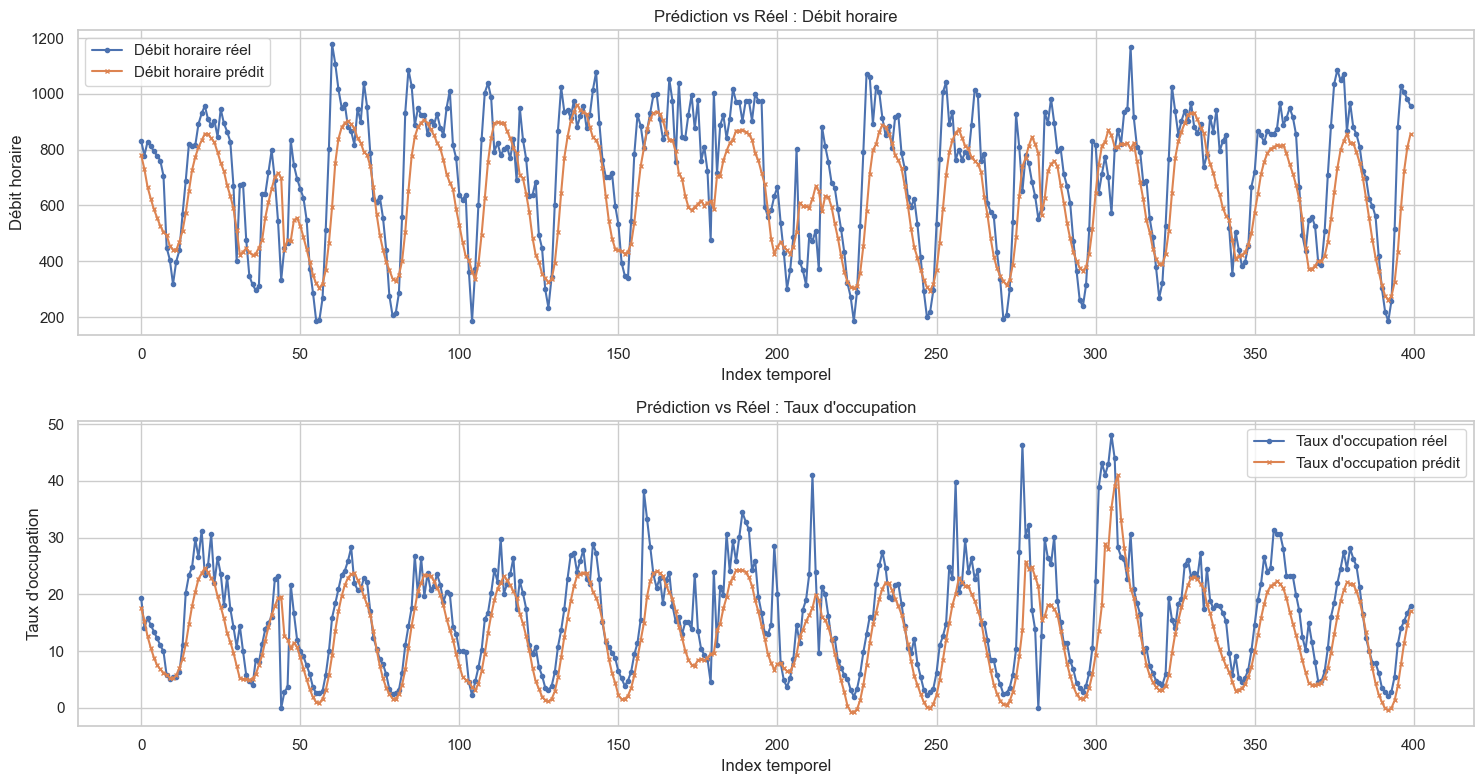

In [14]:
# Définition des targets et features
targets = ['Débit horaire', "Taux d'occupation"]
features = [
    'hour_sin', 'hour_cos', 
    'weekday_sin', 'weekday_cos', 
    'month_sin', 'month_cos', 
    'dayofyear_sin', 'dayofyear_cos',
    'is_weekend', 'is_holiday',
    'Vacances Scolaires Paris', 
    'temperature_2m (°C)', 'wind_speed_10m (km/h)',
    'precipitation (mm)', 'cloud_cover (%)',
    'Débit horaire_outlier_high', 'Débit horaire_outlier_low', 'Débit horaire_special_event',
    "Taux d'occupation_outlier_high", "Taux d'occupation_outlier_low", "Taux d'occupation_special_event"
]

# 1. Préparer les données
X_train, X_test, y_train, y_test, scaler_X, scaler_y = prepare_data(df_champs, features, targets, seq_length=168)

# 2. Entraîner le modèle
model, history = train_lstm_24(X_train, y_train, X_test, y_test, lstm_units=64, dropout=0.2, epochs=3, batch_size=32)

# 3. Évaluer le modèle
y_test_inv, y_pred_inv = evaluate_model(model, X_test, y_test, scaler_y, targets)

# 4. Plot des prédictions
plot_predictions(y_test_inv, y_pred_inv, targets, n_plot=400) 

In [165]:
import pandas as pd

# S'assurer que la colonne date est en datetime
df_champs['date'] = pd.to_datetime(df_champs['date'])

# Dates à filtrer
dates_to_check = ['2024-11-11', '2025-07-14']

# Filtrer
filtered_dates = df_champs[df_champs['date'].dt.strftime('%Y-%m-%d').isin(dates_to_check)]

# Afficher les colonnes d'intérêt
display(filtered_dates[['date', 'hour', 'Débit horaire', "Taux d'occupation"]])


,date,hour,Débit horaire,Taux d'occupation
980,2024-11-11,0,825.000000,15.398340
981,2024-11-11,1,755.000000,11.887780
982,2024-11-11,2,680.000000,8.979450
983,2024-11-11,3,406.000000,4.965000
984,2024-11-11,4,269.000000,2.698340
985,2024-11-11,5,273.000000,6.171110
986,2024-11-11,6,317.000000,3.441670
987,2024-11-11,7,217.000000,2.250000
988,2024-11-11,8,74.000000,0.897220
989,2024-11-11,9,53.000000,0.430560



Débit horaire : 2 valeurs aberrantes


,date,hour,Débit horaire
2446,2025-02-02,11,2190.0
5981,2025-07-02,17,1587.0


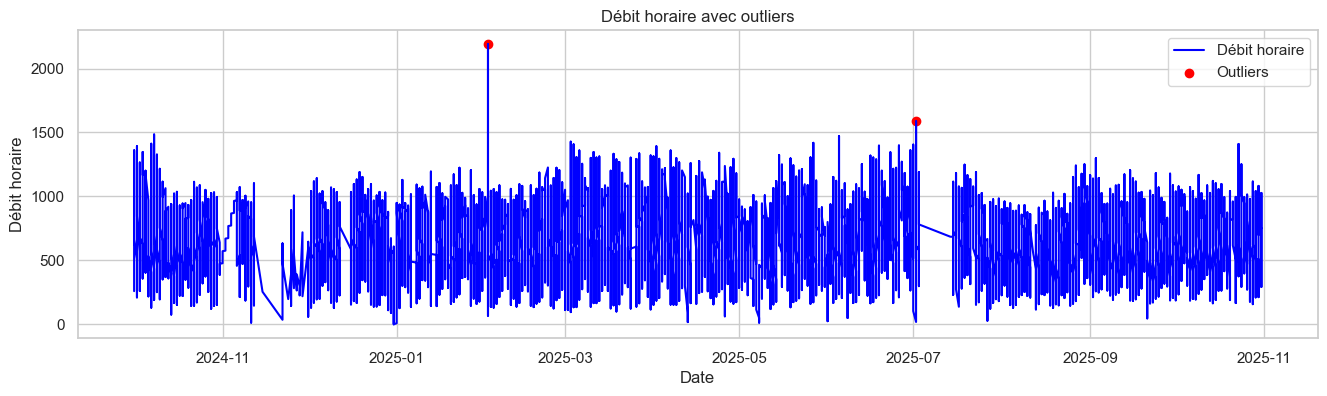


Taux d'occupation : 96 valeurs aberrantes


,date,hour,Taux d'occupation
1298,2024-12-11,15,66.403890
1317,2024-12-12,10,60.820560
1319,2024-12-12,12,55.766110
1320,2024-12-12,13,52.722230
1321,2024-12-12,14,52.535560
1322,2024-12-12,15,53.183890
1323,2024-12-12,16,50.250560
1324,2024-12-12,17,49.803359
1325,2024-12-12,18,49.356157
1326,2024-12-12,19,48.908956


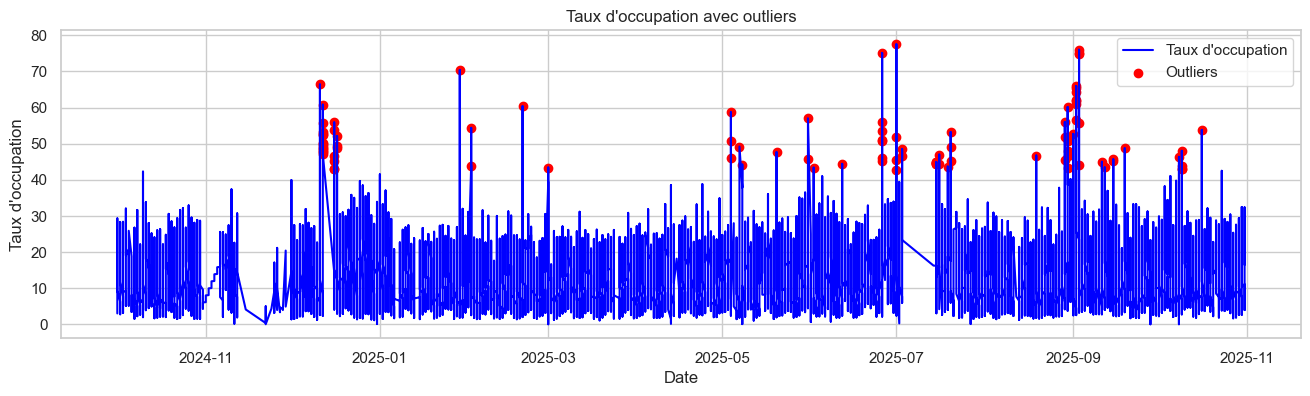

In [153]:
import matplotlib.pyplot as plt

targets = ['Débit horaire', "Taux d'occupation"]

outliers_info = {}

for t in targets:
    Q1 = df_champs[t].quantile(0.25)
    Q3 = df_champs[t].quantile(0.75)
    IQR = Q3 - Q1
    lower = Q1 - 1.5 * IQR
    upper = Q3 + 1.5 * IQR
    
    # Filtrer les outliers
    outliers = df_champs[(df_champs[t] < lower) | (df_champs[t] > upper)]
    
    # Récupérer date et heure
    outliers_info[t] = outliers[['date', 'hour', t]]
    print(f"\n{t} : {len(outliers)} valeurs aberrantes")
    display(outliers_info[t].head(10))  # affiche les 10 premiers

    # Plot
    plt.figure(figsize=(16,4))
    plt.plot(df_champs['date'], df_champs[t], label=t, color='blue')
    plt.scatter(outliers['date'], outliers[t], color='red', label='Outliers')
    plt.title(f"{t} avec outliers")
    plt.xlabel("Date")
    plt.ylabel(t)
    plt.legend()
    plt.show()




=== Analyse des outliers pour : Débit horaire ===
⚠️ Outliers détectés (hauts et bas) :
           date  hour  Débit horaire
2446 2025-02-02    11         2190.0
5981 2025-07-02    17         1587.0
1713 2024-12-31    22            0.0
1714 2024-12-31    23            0.0
1712 2024-12-31    21            1.0
1711 2024-12-31    20            2.0
1715 2025-01-01     0            8.0
990  2024-11-11    10           13.0
4669 2025-05-08    18           13.0
4668 2025-05-08    17           15.0
4093 2025-04-13     2           17.0
5964 2025-07-02     0           18.0
1708 2024-12-31    17           24.0
5236 2025-06-01    16           24.0
991  2024-11-11    11           26.0
4097 2025-04-13     6           26.0
4095 2025-04-13     4           27.0
6313 2025-07-27    13           28.0
5965 2025-07-02     1           29.0
5234 2025-06-01    14           32.0
4667 2025-05-08    16           33.0
4094 2025-04-13     3           34.0


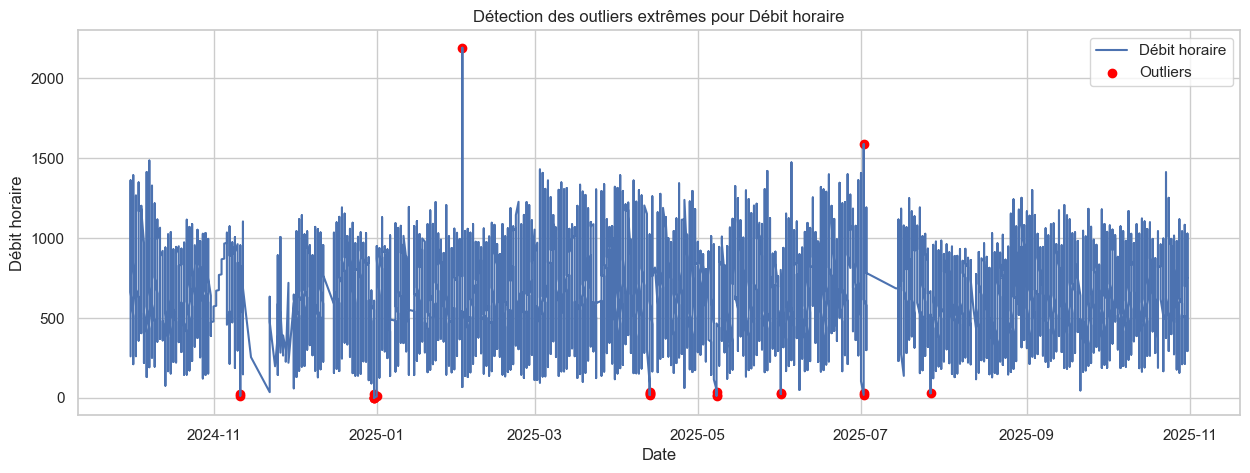


=== Analyse des outliers pour : Taux d'occupation ===
⚠️ Outliers détectés (hauts et bas) :
           date  hour  Taux d'occupation
1298 2024-12-11    15          66.403890
1317 2024-12-12    10          60.820560
1319 2024-12-12    12          55.766110
1320 2024-12-12    13          52.722230
1321 2024-12-12    14          52.535560
1322 2024-12-12    15          53.183890
1323 2024-12-12    16          50.250560
1324 2024-12-12    17          49.803359
1325 2024-12-12    18          49.356157
1326 2024-12-12    19          48.908956
1327 2024-12-12    20          48.461754
1328 2024-12-12    21          48.014553
1329 2024-12-12    22          47.567352
1330 2024-12-12    23          47.120150
1343 2024-12-16    12          55.886110
1344 2024-12-16    13          53.796670
1345 2024-12-16    14          46.523340
1346 2024-12-16    15          45.232780
1349 2024-12-16    18          42.994450
1350 2024-12-16    19          43.037220
1365 2024-12-17    10          49.406670
1367 

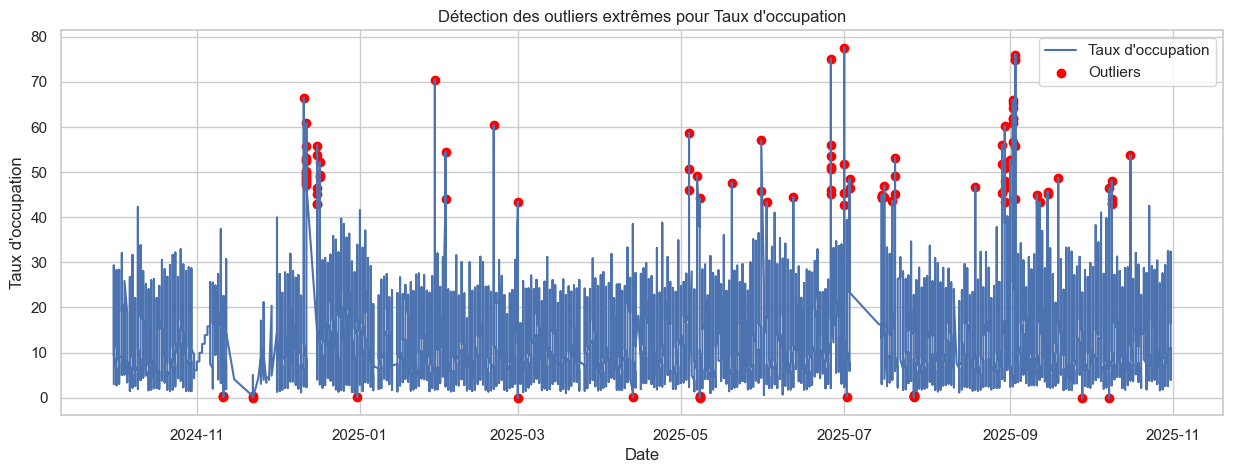

In [155]:
import matplotlib.pyplot as plt

targets = ['Débit horaire', "Taux d'occupation"]

for target in targets:
    print(f"\n=== Analyse des outliers pour : {target} ===")
    
    # Détection des outliers hauts avec IQR
    q1 = df_champs[target].quantile(0.25)
    q3 = df_champs[target].quantile(0.75)
    iqr = q3 - q1

    upper_bound = q3 + 1.5 * iqr
    high_outliers = df_champs[df_champs[target] > upper_bound]

    # Détection des valeurs très basses : les 20 plus petites
    low_outliers = df_champs.nsmallest(20, target)

    # Concaténation pour affichage
    all_outliers = pd.concat([high_outliers, low_outliers]).drop_duplicates()

    # Affichage des dates et heures des outliers
    print("⚠️ Outliers détectés (hauts et bas) :")
    print(all_outliers[['date', 'hour', target]])

    # Plot
    plt.figure(figsize=(15,5))
    plt.plot(df_champs['date'], df_champs[target], label=target)
    plt.scatter(all_outliers['date'], all_outliers[target], color='red', label='Outliers')
    plt.xlabel('Date')
    plt.ylabel(target)
    plt.title(f'Détection des outliers extrêmes pour {target}')
    plt.legend()
    plt.show()


# LSTM 72h

236/236 ━━━━━━━━━━━━━━━━━━━━ 16s 62ms/step - loss: 0.0102 - val_loss: 0.0037
27/27 ━━━━━━━━━━━━━━━━━━━━ 1s 25ms/step
âœ… Débit horaire : RMSE = 199.45, Moyenne = 736.82, Erreur relative = 27.07%
âœ… Taux d'occupation : RMSE = 6.21, Moyenne = 15.97, Erreur relative = 38.91%


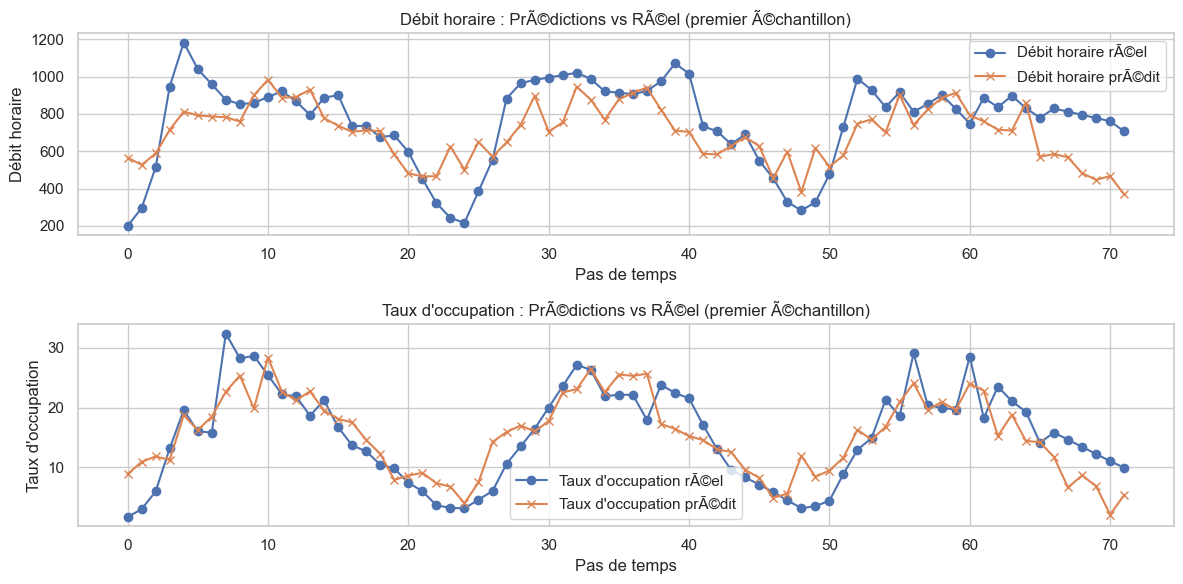

In [25]:
# 🔹 Appel du training
model, history, scaler_X, scalers_y, X_test, y_test = train_lstm_seq2seq(
    df=df_champs,
    features=features,
    targets=targets,
    seq_length=168,
    pred_length=72,
    epochs=1,
    batch_size=32,
    log_transform=False
)
# 2️⃣ Évaluation et plot des prédictions
y_test_inv, y_pred_inv = evaluate_lstm_seq2seq(model, X_test, y_test, scalers_y, targets, n_plot=72)
